## License

This notebook is a conversion of a Sentinel Hub evalscript and is licensed under
**CC-BY-SA-4.0**.

Original evalscript: https://custom-scripts.sentinel-hub.com/sentinel-2/bais2/
Source: Sentinel Hub Custom Scripts (CC-BY-SA-4.0)
Conversion: Development Seed (openEO-UDP project)


# Burned Area Index for Sentinel-2 (BAIS2) and openEO

This notebook demonstrates how to detect burned area at 20 m spatial resolution using Sentinel-2 imagery. The new MSI sensor aboard Sentinel-2 satellites carries more spectral information recorded in the red-edge spectral region, opening the development BAIS2.

## Overview

In this notebook, we will:
1. Connect to an OpenEO backend service
2. Define an area of interest containing terrestrial land, such as Las Palmas de Grand Canaria, Spain
3. Load Sentinel-2-L2A imagery for a specific date, which is 19 August 2019
4. Calculate BAIS2 and estimate burn scars on land
5. Generate a color-mapped visualization based on the minimum and maximum values of BAIS2

## What is BAIS2?
BAIS2 is a spectral index to map burned areas using the red-edge spectral region of Sentinel-2, along with the NIR and SWIR bands. The red-edge region, a strong descriptor of chlorophyll content, is suitable for discriminating burn severity at 20 m spatial resolution. 

The index ranges from -1 to 1 for burn scars and 1 to 6 for active fires, though thresholds may varu with fire intensity and were originally calibrated for Mediterranean environments. BAIS2 enables a reliable detection of fire-damaged areas and supports burned-area mapping from high-resolution optical satellite data. BAIS2 is  calculated as follows:

\begin{equation*}
BAIS2 = \Bigl(1 - \sqrt{\frac{B06 \times B07 \times B8A}{B04}}\Bigr) \times \Bigl(\frac{B12 - B8A}{\sqrt{B12 + B8A}} + 1\Bigr)
\end{equation*}

Where: 
- B06 (740.5 nm): Vegetation red edge band
- B07 (782.8 nm): Vegetation red edge band
- B8A (864.7 nm): Narrow NIR
- B04 (664.6 nm): Red
- B12 (2202.4 nm): SWIR


## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [2]:
import openeo
import matplotlib.pyplot as plt
from PIL import Image
from openeo.processes import array_create, if_

## Connect to OpenEO Backend

Connect to the OpenEO backend and authenticate using OpenID Connect.

In [ ]:
# If I created this connection, I can't process data using load_collection
# When sending job to backend I got an error : Data not existent for the extent
# connection = openeo.connect(
#     url="https://api.explorer.eopf.copernicus.eu/openeo"
# ).authenticate_oidc_authorization_code()

In [ ]:
# Using this connection, I can process data using load_collection
# But there's a credit limit
connection = openeo.connect(
    url="https://openeo.dataspace.copernicus.eu/"
).authenticate_oidc()

Authenticated using refresh token.


## Define Area of Interest

Define the spatial extent for our analysis. This example uses coordinates Las Palmas de Grand Canaria, Spain. You can modify these coordinates to analyze any terrestrial land prone to fire.

In [29]:
# AOI for Las Palmas de Grand Canaria, Spain
spatial_extent = {"west" : -15.91, "south" : 27.73, "east" : -15.29, "north" : 28.22}

## Load Sentinel-2 Data

Load Sentinel-2 L2A (bottom-of-atmosphere reflectance) data. We need multiple bands for BAIS2 calculation:

- **B04** (Red, 664.6 nm): Red band
- **B06** (Red Edge, 740.5 nm): Vegetation red edge band
- **B07** (Red Edge, 782.8 nm): Vegetation red edge band
- **B8A** (Narrow NIR, 864.7 nm): Narrow NIR
- **B12** (SWIR, 2202.4 nm): SWIR band

In [ ]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=["2019-08-19", "2019-08-30"], # 
    bands=[
        "B04", 
        "B06", 
        "B07", 
        "B8A", 
        "B12"
    ],
)

# Filter for a specific date
s2cube = s2cube.filter_temporal(
    ["2019-08-19", "2019-08-19"]
)

## Calculate Burned Area Index for Sentinel-2

**BAIS2 = (1 − √((B06 × B07 × B8A) / B04)) × ( (B12 − B8A) / √(B12 + B8A) + 1 )**

In [ ]:
def bais2_visualization(data):
    # Extract bands
    B04, B06, B07, B8A, B12 = (
        data[0],
        data[1],
        data[2],
        data[3],
        data[4]
    )
    
    # Scale bands from digital numbers (0-10000) to reflectance (0-1)
    # This must be done BEFORE the calculation to get correct BAIS2 values
    B04 = B04 / 10000.0
    B06 = B06 / 10000.0
    B07 = B07 / 10000.0
    B8A = B8A / 10000.0
    B12 = B12 / 10000.0

    # Calculate BAIS2 using the scaled reflectance values
    bais = (1 - ((B06 * B07 * B8A) / B04) ** 0.5) * ((B12 - B8A) / ((B12 + B8A) ** 0.5) + 1)

    min_val = 0.0
    max_val = 0.99
    zero_threshold = 0.5 # Diverging colormap break point from min to max

    # Create spatial ones for color calculations
    spatial_ones = bais * 0 + 1

    # Color mapping: White when index is below minimum
    underflow = array_create(
        [
            spatial_ones * 1.0,
            spatial_ones * 1.0,
            spatial_ones * 1.0  
        ]
    )

    # Color mapping: Blue when index is between zero and zero_threshold
    low_color = array_create(
        [
            spatial_ones * 0.0,
            spatial_ones * 0.0,
            spatial_ones * 1.0
        ]
    )

    # Color mapping: Red when index is between zero_threshold and max_val
    high_color = array_create(
        [
            spatial_ones * (255 / 255),
            spatial_ones * (20 / 255),
            spatial_ones * (20 / 255)
        ]
    )

    # Color mapping: Yellow when index is near zero_threshold
    zero_color = array_create(
        [
            spatial_ones * (250 / 255),
            spatial_ones * (255 / 255),
            spatial_ones * (10 / 255)
        ]
    )

    # Color mapping: Magenta when index is above max_val
    overflow = array_create(
        [
            spatial_ones * (255 / 255),
            spatial_ones * (0 / 255),
            spatial_ones * (255 / 255)
        ]
    )

    def linear_interpolation(color_a, color_b, bais_val, val_min, val_max):
        t = (bais_val - val_min) / (val_max - val_min)
        r = color_a[0] + (color_b[0] - color_a[0]) * t
        g = color_a[1] + (color_b[1] - color_a[1]) * t
        b = color_a[2] + (color_b[2] - color_a[2]) * t
        return array_create([r, g, b])

    result = if_(
        bais < min_val,
        underflow,
        if_(
            bais < zero_threshold,
            linear_interpolation(low_color, zero_color, bais, min_val, zero_threshold),
            if_(
                bais <= max_val,
                linear_interpolation(zero_color, high_color, bais, zero_threshold, max_val),
                overflow
            )
        )
    )
    return result

    

In [ ]:
bais2_image = s2cube.apply_dimension(
    dimension="bands",
    process=bais2_visualization
)

bais2_image = bais2_image.linear_scale_range(input_min=0, input_max=1, output_min=0, output_max=255)

bais2_image = bais2_image.save_result("PNG")

In [ ]:
# Send job to backend and download the result
bais2_image.download("bais2_burned_area_1d.png")

## Visualize the Result

Display the generated BAIS2 map with the color-coded legend.

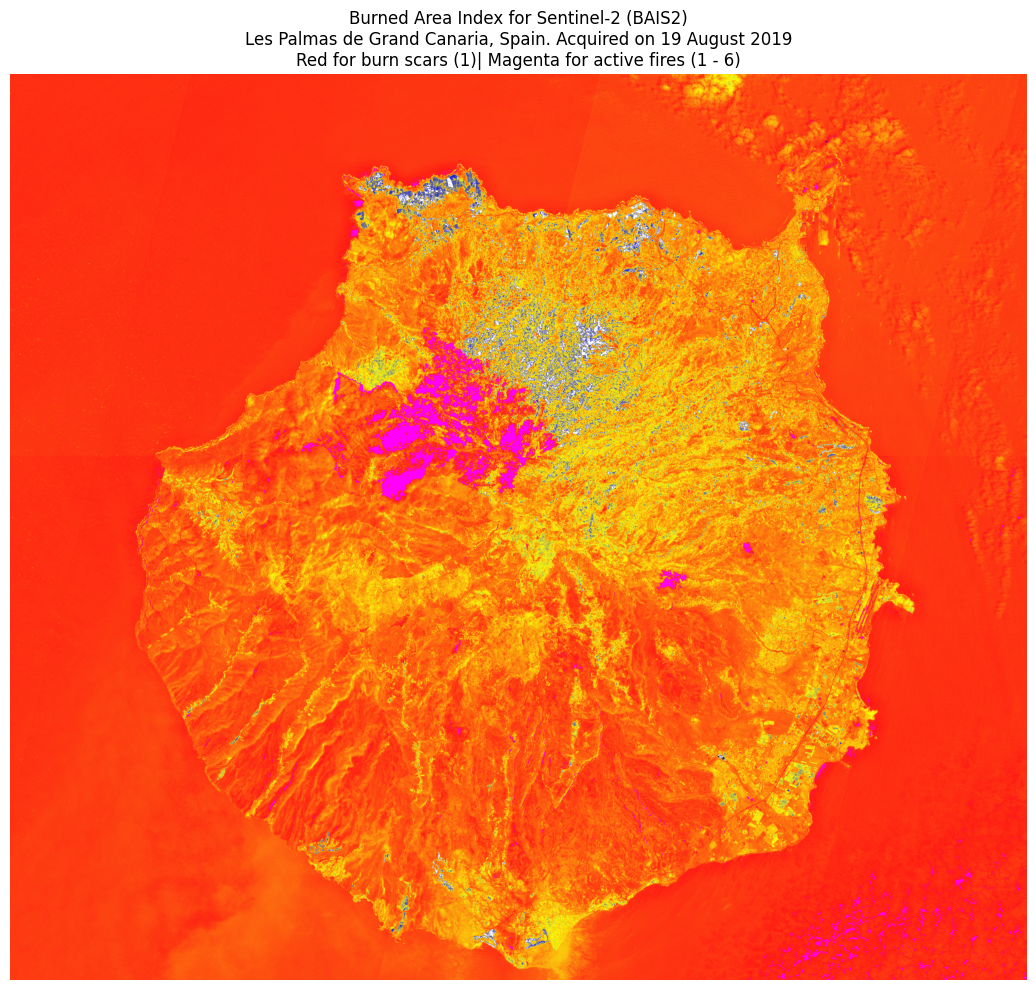

In [3]:
# Load and display the image
img = Image.open("bais2_burned_area_1d.png")

fig, ax = plt.subplots(figsize=(14, 10), dpi=100)
ax.imshow(img)
ax.set_title(
    "Burned Area Index for Sentinel-2 (BAIS2)\n"
    "Les Palmas de Grand Canaria, Spain. Acquired on 19 August 2019\n"
    "Red for burn scars (1)| Magenta for active fires (1 - 6)",
    fontsize=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

## Interpretation Guide

### BAIS2 Value Guide
| Color Gradient | BAIS2 Range | Interpretation |
|-------|-------------------|----------------------|
| Blue -> Yellow -> Orange -> Red | -1 to 1 | Burn scars from low to high severity |
| Red -> Magenta | 1 to 6 | High severity burn scars to active fires |

**Notes on the thresholds**
- Thresholds may vary depending on fire intensity
- Current thresholds follow the calibration of the original author, optimized for Mediterranean regions

### Applications:
- Burned area mapping: Detecting and delineating burn scars using Sentinel-2 red-edge bands
- Fire severity assessment: Using BAIS2 and dBAIS2 (Difference Burned Area Index for Sentinel-2) to evaluate changes in fire severity pre- and post-fire

### Method Overview
- The method had been tested to map wildfires in Sicily region, Italy, in 2017. BAIS2 results showed good agreements with the burned area polygons of Copernicus EMS products. The test also highlighted utilising the BAIS2 with biophysical estimates such as LAF for the evaluation of fire severity levels in a more comprehensive manner
- BAIS2 is derived from Sentinel-2 MSI red-edge spectral bands, which are good indicators for chlorophyll contents
- The adoption of difference indices (i.e., dBAIS2 and dNBR) is demonstrated to gather better results when compared to a single temporal observation because they rely on the estimation of changing vegetation cover

### Performance and Insights
- Good discrimination of burned areas
- Burn severity classification can be dataset-dependent, with common misclassification at low-severity levels

### Limitations
- Water masking required. Water bodies could be removed to avoid false burn signals due to spectral darkness
- Cloud shadows could be masked to prevent misclassification
- Index thresholds vary with region and acquisition conditions
- Charcoal remval and early vegetation regrowth can affect SWIR-based indices
- Bidirectional reflectance distribution function (BRDF) should be minimized to enable reliable mapping of surface features and the detection of surface change, as well as to provide consistent sensor data comparison

### Recommended Practices
- Use difference indices for detecting changes due to fire
- Employ dense time series to identify fire timing, reduce classification errors, and mitigate SWIR reflectance variability
- Apply robust masking (water, cloud, shadow) before analysis

## Citation
Filipponi, F. (2018). *BAIS2 – Burned Area Index for Sentinel-2*.  
2nd International Electronic Conference on Remote Sensing, **Proceedings**, 2(7), 364. https://doi.org/10.3390/ecrs-2-05177 

## Attribution

This openEO User-Defined Process is a conversion of the original Sentinel Hub evalscript:

**Original Script:** [BAIS2 (Burned Area Index for Sentinel 2)](https://custom-scripts.sentinel-hub.com/sentinel-2/bais2/)

**Author:** Harel Dan, @hareldan, harel.dunn@gmail.com

**Source Repository:** [Sentinel Hub Custom Scripts](https://github.com/sentinel-hub/custom-scripts)

This conversion maintains the scientific methodology and visualization approach of the original evalscript while adapting it to the openEO process graph framework for interoperability across openEO-compliant backends.

## Conclusion

This notebook demonstrates the implementation of Burned Area Index for Sentinel-2 estimation for mapping burned areas using openEO and Sentinel-2 imagery. The notebook succesfully:

- Identifies burned areas using multiple spectral indices
- Produces color-mapped visualizations with gradients

The approach can be extended to:

- Create time-series animations to identify fire events on land surface and/or based on vegetation conditions
- Produce statistical summaries of total burned area
- Integrate the outputs into early-warning systems and fire-risk monitoring system
- Support modelling of fire spread and intensity under varying climate conditions
- Validate results using ground-based observations and field data
- Enhance post-fire recovery monitoring by assessing vegetation growth over time
- Improve classification accuracy by combining BAIS2 outputs with other spectral or biophysical indices, as well as by implementing machine learning models